# COVID-19 EDA and Hypothesis Testing

### Data is sourced from:

https://github.com/nytimes/covid-19-data

### Other sources:

https://covidtracking.com/data/state/california/
https://covidtracking.com/api
https://covid19.healthdata.org/projections

In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats as stats
import random
from datetime import datetime,date

In [2]:
plt.style.use('fivethirtyeight')

## Explore and clean the data

#### Load the data into a Pandas DataFrame

In [3]:
us_covid = pd.read_csv('../datasets/covid-19-data/us-states.csv')
us_covid_cases = us_covid[['date', 'state', 'cases']].copy()
dates = us_covid['date'].unique()
states = us_covid['state'].unique()

#### Use a pivot table to move the data into columns/rows.

In [4]:
us_covid_cases_table = us_covid_cases.pivot(index='state', columns='date', values='cases')
us_covid_cases_table.fillna(0, inplace=True)

In [5]:
us_covid_cases_table.head()

date,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,720.0,830.0,947.0,999.0,1106.0,1270.0,1535.0,1633.0,1841.0,2006.0
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,102.0,114.0,119.0,133.0,143.0,146.0,156.0,169.0,185.0,189.0
Arizona,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,773.0,929.0,1169.0,1298.0,1413.0,1600.0,1769.0,2019.0,2269.0,2465.0
Arkansas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,409.0,449.0,508.0,564.0,624.0,683.0,738.0,743.0,853.0,927.0
California,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,...,5565.0,6266.0,7421.0,8582.0,9816.0,11190.0,12569.0,13796.0,15076.0,16284.0


#### Convert column names to date time objects.

In [6]:
us_covid_cases_table.columns = pd.to_datetime(us_covid_cases_table.columns)

In [7]:
print(us_covid_cases_table.columns[0])
print(type(us_covid_cases_table.columns[0]))

2020-01-21 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


#### Display table for number of cases

In [8]:
us_covid_cases_table.head()

date,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,720.0,830.0,947.0,999.0,1106.0,1270.0,1535.0,1633.0,1841.0,2006.0
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,102.0,114.0,119.0,133.0,143.0,146.0,156.0,169.0,185.0,189.0
Arizona,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,773.0,929.0,1169.0,1298.0,1413.0,1600.0,1769.0,2019.0,2269.0,2465.0
Arkansas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,409.0,449.0,508.0,564.0,624.0,683.0,738.0,743.0,853.0,927.0
California,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,...,5565.0,6266.0,7421.0,8582.0,9816.0,11190.0,12569.0,13796.0,15076.0,16284.0


## For this study, I'm only considering percent increases once the state has over 10 cases. 

That way, I am getting rid of the bias of those first couple of days (e.g., when a state goes from 1 case to 2 cases, it's a 100% increase).

In [9]:
us_covid_cases_table[us_covid_cases_table < 10] = 0

#### Create empty array for the daily increases percent = (that days # - prev days #) / prev day

In [10]:
us_covid_increases = pd.DataFrame(index=us_covid_cases_table.index.values, 
                                  columns=us_covid_cases_table.columns.values)
us_covid_increases.fillna(0, inplace=True)


#### Fill empty array with the daily increases from the us_covid_cases_table data

In [11]:
for each_date in us_covid_increases.columns.values[1:]:
    us_covid_increases[each_date] = ((us_covid_cases_table[each_date] -
                                         us_covid_cases_table[each_date - pd.Timedelta(days=1)]) / 
                                         us_covid_cases_table[each_date - pd.Timedelta(days=1)]) * 100

#### Display table for percent increases

In [12]:
#us_covid_increases

#### Change 'NaN' and 'inf' values to 0 

NaN occurs when there were no record cases on that day and the day before (e.g., 0/0)

Inf occurs when there was a case reported on that day but none on the day before (e.g., 1/0)

In [13]:
us_covid_increases.fillna(0, inplace=True)
us_covid_increases.replace(np.inf, 0, inplace=True)

In [14]:
us_covid_increases.head()

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06
Alabama,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.676056,15.277778,14.096386,5.491024,10.710711,14.828210,20.866142,6.384365,12.737293,8.962520
Alaska,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.000000,11.764706,4.385965,11.764706,7.518797,2.097902,6.849315,8.333333,9.467456,2.162162
Arizona,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.240602,20.181113,25.834230,11.035073,8.859784,13.234253,10.562500,14.132278,12.382368,8.638167
Arkansas,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.958549,9.779951,13.140312,11.023622,10.638298,9.455128,8.052709,0.677507,14.804845,8.675264
California,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.247863,12.596586,18.432812,15.644792,14.378933,13.997555,12.323503,9.762113,9.278052,8.012735


#### Reset the index for the table to be named 'state'

In [15]:
us_covid_increases.index.name = 'state'

In [16]:
us_covid_increases.head()

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.676056,15.277778,14.096386,5.491024,10.710711,14.828210,20.866142,6.384365,12.737293,8.962520
Alaska,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.000000,11.764706,4.385965,11.764706,7.518797,2.097902,6.849315,8.333333,9.467456,2.162162
Arizona,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.240602,20.181113,25.834230,11.035073,8.859784,13.234253,10.562500,14.132278,12.382368,8.638167
Arkansas,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.958549,9.779951,13.140312,11.023622,10.638298,9.455128,8.052709,0.677507,14.804845,8.675264
California,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.247863,12.596586,18.432812,15.644792,14.378933,13.997555,12.323503,9.762113,9.278052,8.012735


In [17]:
print(us_covid_cases_table.columns[0])
print(type(us_covid_cases_table.columns[0]))

2020-01-21 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


#### Make the columns for dates be datetime objects.

## Load in the dates for stay-at-home orders

Dates were scrapped from https://www.kff.org/coronavirus-policy-watch/stay-at-home-orders-to-fight-covid19/

In [18]:
stay_home_dates = pd.read_pickle('../datasets/stay_home_orders_pickled.pkl')

In [19]:
stay_home_dates.head()

,Date Announced,Effective Date
state,,
Alabama,2020-04-03,2020-04-04
Alaska,2020-03-27,2020-03-28
Arizona,2020-03-30,2020-03-31
California,2020-03-19,2020-03-19
Colorado,2020-03-26,2020-03-26


In [20]:
print(stay_home_dates.iloc[1,1])
print(type(stay_home_dates.iloc[1,1]))

2020-03-28 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Merge the percent increases and the stay-at-home order date dataframes

This will drop the states that have not implemented stay-at-home orders, which is good for this study because we're trying to answer the original question.

Also drops the non-state entries from us_covid_increases table.

In [21]:
us_covid_with_dates = pd.merge(us_covid_increases, stay_home_dates, on='state')

### Drop the Date Announced column

In [22]:
us_covid_with_dates.drop(['Date Announced'], axis=1, inplace=True)

In [23]:
us_covid_with_dates.head()

,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,...,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,Effective Date
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.277778,14.096386,5.491024,10.710711,14.828210,20.866142,6.384365,12.737293,8.962520,2020-04-04
Alaska,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.764706,4.385965,11.764706,7.518797,2.097902,6.849315,8.333333,9.467456,2.162162,2020-03-28
Arizona,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.181113,25.834230,11.035073,8.859784,13.234253,10.562500,14.132278,12.382368,8.638167,2020-03-31
California,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.596586,18.432812,15.644792,14.378933,13.997555,12.323503,9.762113,9.278052,8.012735,2020-03-19
Colorado,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.324115,13.520518,13.774734,11.906355,11.416617,12.178112,9.373505,8.220376,4.484848,2020-03-26


In [24]:
print(us_covid_with_dates.columns[0])
print(type(us_covid_with_dates.columns[0]))

2020-01-21 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [25]:
print(us_covid_with_dates.iloc[1, -1])
print(type(us_covid_with_dates.iloc[1,-1]))

2020-03-28 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Plot the Percent Increases Over Time

In [26]:
def plot_percent_changes(ax, data, dates, label):
    '''Plots the dates/data on the given axis and applies a label to it.
    Inputs
    ------
    ax: matplotlib ax to plot on
    data: float with last entry being date in which the stay-at-home order was effective.
    dates: pandas._libs.tslibs.timestamps.Timestamp with last entry being 'Effective Date'
    label: string
    
    Returns
    -------
    None
    '''
    #strip data of stay-at-home order date
    data_ = data[:-1]
    #get only the data that is more than 0
    data_greater = data_[data_>0]
    
    #strip dates of last entry
    dates_ = dates[:-1]
    #get only the dates that the data is more than 0
    dates_greater = dates_[data_>0] 
    
    ax.plot(dates_greater, data_greater, label = label)
    
    #plot a vertical line at the stay-at-home date
    stay_home_date = data[-1]
    
    ax.axvline(stay_home_date, color="red", linestyle="--", 
               label='stay-home date')

In [27]:
def generate_labels(ax):
    ax.legend(fontsize=14)
    fig.autofmt_xdate()
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 4));
    ax.set_ylabel('Percent Change Per Day')
    ax.yaxis.label.set_size(20)
    ax.set_xlabel('Date')
    ax.xaxis.label.set_size(20)

In [28]:
def plot_social_distance(ax, date):
    '''Plots vertical line on axis that shows the date at which social distancing was implemented.
    Inputs
    ------
    ax: matplotlib ax to plot on
    dates: pandas._libs.tslibs.timestamps.Timestamp with last entry being 'Effective Date'
    label: string
    
    Returns
    -------
    None   
    
    '''
    ax.axvline(date, color="green", linestyle="--", 
               label='social distancing date')

In [29]:
def get_social_distance_date():
    federal_dist_date = '2020-03-16'
    federal_dist_date = pd.to_datetime(federal_dist_date)
    return federal_dist_date

/Users/tjwoo/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


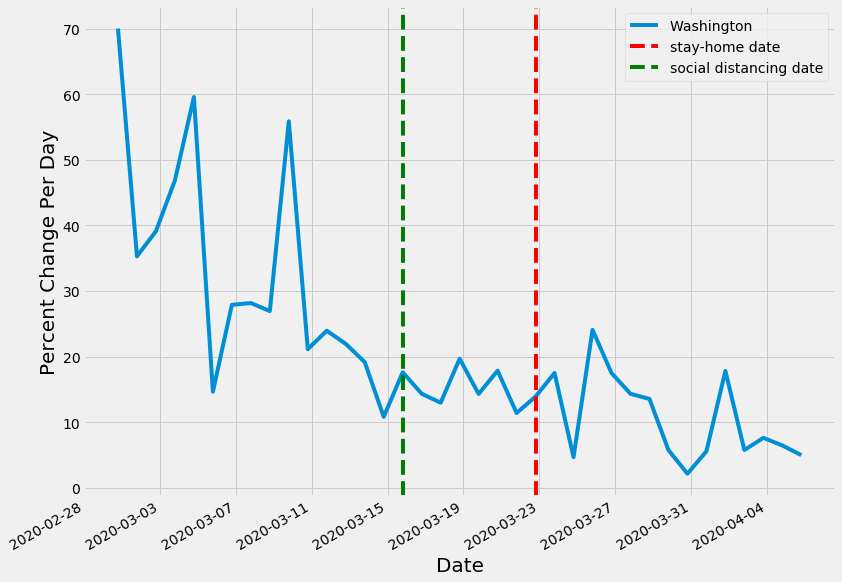

In [30]:
fig, ax = plt.subplots(figsize=(12,10))
plot_percent_changes(ax, us_covid_with_dates.loc['Washington', :], 
                     us_covid_with_dates.columns, 'Washington')
plot_social_distance(ax, get_social_distance_date())
generate_labels(ax)

## Hypothesis Testing and Statistical Power Analysis

### Null Hypothesis Signficance Testing Procedure

##### 1. State a scientific yes/no question.

Question: Do stay-at-home guidelines provide a change in the percent increase of the number of COVID-19 cases that a state reports?

##### 2. Take a skeptical stance: State a null hypothesis.

H_0: The social distancing guidelines do not provide a change in the percent increase of COVID-19 cases that a state reports.

##### 3. State the opposite of your null hypothesis: the alternative hypothesis.

H_A: Social distancing guidelines provide a 30% decrease in percent daily increases.

##### 4. Create a probabilistic model of the situation when the null hypothesis is true.

$$ \text{Difference in percent increase averages | H0} \sim Normal \left( 0, \sqrt{\frac{\sigma^2 (pre)}{num days pre} + \frac{\sigma^2 (post)}{num days post}} \right) $$

##### 5. Determine how surprised you need to be to reject the null: Determine a rejection level alpha.

$$ \alpha = 0.05 $$

##### 6. Collect your data.

> Look at Washington first

##### 7. Calculate the conditional probability of finding a result equally or more extreme that you actually observed, assuming the null is true: This is your p-value.

In [31]:
def calc_p_value(data1, data2):
    stat, p_val = stats.ttest_ind(data1, data2, equal_var = False)
    return p_val

In [32]:
# Percent increase for pre-social distancing

washington_pre = us_covid_with_dates.loc['Washington', :get_social_distance_date() + 
                        pd.Timedelta(days=7)]
washington_pre = washington_pre[washington_pre>0]

In [33]:
# Percent increase for post-social distancing

last_date_entry = us_covid_with_dates.columns[-2]

washington_post = us_covid_with_dates.loc['Washington', 
                                          get_social_distance_date() + 
                                          pd.Timedelta(days=8):last_date_entry]
washington_post = washington_post[washington_post>0]

In [37]:
wash_p_value = calc_p_value(washington_pre, washington_post)

##### 8. Compare the p-value to your stated rejection threshold, reject the null hypothesis if the p-value is smaller than your rejection level alpha.

In [38]:
def compare_p_value(p_val, alpha):
    if p_val > alpha:
        print("The null hypothesis can NOT be rejected.")
    else:
        print("The null hypothesis can be rejected.")

In [39]:
compare_p_value(wash_p_value, 0.05)

The null hypothesis can be rejected.


### Statistical Power

If it is assumed a specific, precise effect, then the difference in average **is** normally distributed. Under this assumption, our data on mean difference in percent increase can be generated.

$$ \text{Mean Percent Daily Increase of COVID-19 Cases (before distancing)} \mid H_0 \sim N\left(Mean Perc Inc (before), \frac{\sigma}{\sqrt{days}}\right)$$

$$ \text{Mean Percent Daily Increase of COVID-19 Cases (after distancing)} \mid H_0 \sim N\left(Mean Perc Inc (after), \frac{\sigma}{\sqrt{days}}\right)$$

$$ \text{Difference in Mean Percent Daily Increase of COVID-19 Cases} \mid H_0 \sim N\left(0, \frac{\sigma}{\sqrt{days}}\right)$$

$$ \text{Mean Percent Daily Increase of COVID-19 Cases} \mid H_A \sim N\left(Mean * .7, \frac{\sigma}{\sqrt{days}}\right)$$


In [ ]:
def get_mean_and_std_error(data):
    '''Takes in an np.array or pandas.Series and returns 
    the mean and std error of the data'''
    
    average = data.mean()
    std_error = data.std() / math.sqrt(len(data))
    
    return average, std_error

##### Washington

In [ ]:
# Percent increase for pre-social distancing

washington_pre = us_covid_with_dates.loc['Washington', :get_social_distance_date() + 
                        pd.Timedelta(days=7)]
washington_pre = washington_pre[washington_pre>0]

In [ ]:
wash_ave_pre, wash_std_error_pre = get_mean_and_std_error(washington_pre)

In [ ]:
# Percent increase for post-social distancing

last_date_entry = us_covid_with_dates.columns[-2]

washington_post = us_covid_with_dates.loc['Washington', 
                                          get_social_distance_date() + 
                                          pd.Timedelta(days=8):last_date_entry]
washington_post = washington_post[washington_post>0]

In [ ]:
wash_ave_post, wash_std_error_post = get_mean_and_std_error(washington_post)

In [ ]:
def get_distribution(mean, std_error) -> 'scipy.stats._distn_infrastructure.rv_frozen':
    '''Takes in an np.array and returns the normal distribution object.'''
    
    distribution = stats.norm(loc=mean, scale=std_error)
    return distribution

##### Washington

Null Hypothesis, H_0

In [ ]:
washington_pre_dist = get_distribution(wash_ave_pre, wash_std_error_pre)

Alternative Hypothesis, H_A

H_A: Social distancing guidelines provide a 10% decrease in percent daily increases.

In [ ]:
washington_alt = get_distribution(wash_ave_pre*0.7, wash_std_error_pre)

#### Plot the sampling distributions of the H_0 and H_A

In [ ]:
def plot_distribution(ax, distribution, mean, std_error, label):
    '''Plots the distribution on an axis.
    Inputs
    -------
    ax: matplotlib axis
    distribution: scipy.stats._distn_infrastructure.rv_frozen
    mean: float
    std_error: float
    title: string to set the axis title to.
    
    Returns
    -------
    None
    
    '''
    
    t = np.linspace(mean - 4*std_error, mean + 4*std_error, num=250)
    
    ax.plot(t, distribution.pdf(t), label=label)

In [ ]:
def generate_labels_dist(ax1):
    ax1.legend(fontsize=15)
    ax1.set_title('Distribution of Percent Increases', fontsize=25)

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))

plot_distribution(ax, washington_pre_dist, wash_ave_pre, 
                  wash_std_error_pre, 'Washington H0')
plot_distribution(ax, washington_alt, wash_ave_pre*0.7, 
                  wash_std_error_pre, 'Washington Alt')
generate_labels_dist(ax)

#### Plot Vertical Line to indicate the bounds for rejecting the null hypthosesis

In [ ]:
def plot_rejection_region(ax, distribution, mean, std_error):
    '''Plot a vertical line to indicate the bounds for rejecting the null hypothesis, 
    assuming a signficance level of 0.05.'''
    
    t = np.linspace(mean - 4*std_error, mean + 4*std_error, num=250)
    
    critical_value_left = distribution.ppf(.05)
    
    ax.axvline(critical_value_left, color="grey", linestyle="--")
    
    tneg = t[t <= critical_value_left]
    ax.fill_between(tneg, 0, distribution.pdf(tneg),
                   color='green', alpha=0.2, label=r"$\alpha$")
    ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
plot_distribution(ax, washington_pre_dist, wash_ave_pre, 
                  wash_std_error_pre, 'Washington H0')
plot_distribution(ax, washington_alt, wash_ave_pre*0.7, 
                  wash_std_error_pre, 'Washington Alt')
plot_rejection_region(ax, washington_pre_dist, wash_ave_pre, 
                      wash_std_error_pre)
generate_labels_dist(ax)

#### Compute the power of the test. Shade area under the alternate hypothesis distribution that indicates the power of the test.

Power is given by the area under the alternate distribution with the rejection region.

In [ ]:
def plot_power_reigons(ax1, distribution_0, distribution_a, mean, std_error):
    t = np.linspace(mean - 4*std_error, mean + 4*std_error, num=250)
    
    critical_value_left = distribution_0.ppf(.05)

    ax.axvline(critical_value_left, color="grey", linestyle="--")
    #ax.axvline(critical_value_right, color="grey", linestyle="--")

    #tpos = t[t >= critical_value_right]
    #ax.fill_between(tpos, 0, ha_dist.pdf(tpos), 
                    #color=color_cycle[1], alpha=0.2, label=r"$\alpha$")

    tneg = t[t <= critical_value_left]
    ax.fill_between(tneg, 0, distribution_a.pdf(tneg), 
                    color='orange', alpha=0.2, label="Power")

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
plot_distribution(ax, washington_pre_dist, wash_ave_pre, 
                  wash_std_error_pre, 'Washington H0')
plot_distribution(ax, washington_alt, wash_ave_pre*0.7, 
                  wash_std_error_pre, 'Washington Alt')
plot_power_reigons(ax, washington_pre_dist, washington_alt, 
                   wash_ave_pre*0.7, wash_std_error_pre)
generate_labels_dist(ax)

In [ ]:
def compute_power_one_tailed(distribution_0, distribution_a):
    """Compute the statistical power of a standard one-tailed z-test.

    Parameters
    ----------

    n: int
      Sample size.  Must be a positive number.

    sigma: float
      Population standard deviation.  Must be a positive number.

    alpha: float
      Significance level.  Must be between zero and one.

    mu0: float
      Assumed population mean under the null hypothesis.

    mua: float
      Assumed population mean under the alternate hypothesis.
    """
    critical_value_left = distribution_0.ppf(.05)
    power = distribution_a.cdf(critical_value_left)
    
    return power

In [ ]:
wash_power = compute_power_one_tailed(washington_pre_dist,washington_alt)

In [ ]:
print("Power to detect effect: {:2.2f}".format(wash_power))

There is a 76% chance we will detect a difference of 30%, when such a difference actually exists.